Vehicle segmentation.

The U-NET model is used.

In [ ]:
!wget https://www.dropbox.com/s/tc1qo73rrm3gt3m/CARVANA.zip
!wget https://www.dropbox.com/s/k886cusbuc1afnq/imagenet-mini.zip
!wget https://gist.githubusercontent.com/yrevar/942d3a0ac09ec9e5eb3a/raw/238f720ff059c1f82f368259d1ca4ffa5dd8f9f5/imagenet1000_clsidx_to_labels.txt  # классы имаджнета

!unzip -q CARVANA.zip -d CARVANA
!unzip -q imagenet-mini.zip

!rm -rf ./train/.DS_Store
!rm -rf ./train_masks/.DS_Store
!rm -rf CARVANA.zip
!rm -rf imagenet-mini.zip

!pip install colour -q
#!pip install pytorch-lightning -q
!pip install wandb

--2023-11-15 01:45:39--  https://www.dropbox.com/s/tc1qo73rrm3gt3m/CARVANA.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.8.18, 2620:100:6018:18::a27d:312
Connecting to www.dropbox.com (www.dropbox.com)|162.125.8.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/tc1qo73rrm3gt3m/CARVANA.zip [following]
--2023-11-15 01:45:39--  https://www.dropbox.com/s/raw/tc1qo73rrm3gt3m/CARVANA.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc90e4588eec8b526ab75f910f73.dl.dropboxusercontent.com/cd/0/inline/CHhi3nW503eednyS7n_q5qCg7rZ8NqpYpUjZ-RWRYwy-gqRljbTfxGbAIH2je7Xz36ll5zf9VaVRmPKf_0uAwzN7JdfqC6Ky--_x4fI3PbqiaDW_h6MEx7sYHBNUQ2Zp__VofeDQivWYoY5y8G4oW_TZ/file# [following]
--2023-11-15 01:45:39--  https://uc90e4588eec8b526ab75f910f73.dl.dropboxusercontent.com/cd/0/inline/CHhi3nW503eednyS7n_q5qCg7rZ8NqpYpUjZ-RWRYwy-gqRljbTfxGbAIH2je7Xz36ll5zf9VaVRmPKf_0uAwzN7JdfqC6Ky--_x4fI3P

In [ ]:
!rm CARVANA/train/.DS_Store

In [ ]:
import glob
import math
import os
import warnings
from typing import Dict, List, Tuple

import matplotlib.pyplot as plt
import numpy as np
#import pytorch_lightning as pl
import torch
import wandb
from PIL import Image
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T

warnings.filterwarnings("ignore")

tensor([0, 1], dtype=torch.uint8)
tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8)


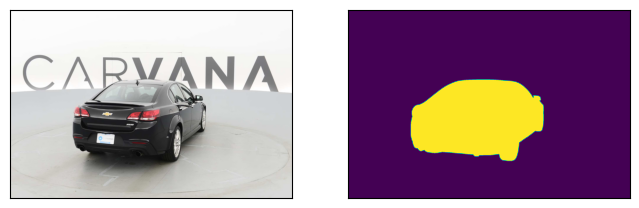

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(8, 6))
filename = os.path.join('CARVANA/train',np.random.choice(os.listdir('CARVANA/train')))
axs[0].imshow(Image.open(filename))
mask_name = os.path.join('CARVANA/train_masks', os.path.basename(filename))
image = Image.open(mask_name[:-4] + "_mask.gif")
tensor = T.PILToTensor()(image)
tensor[tensor == 255] = 1
print(tensor.unique())
print(tensor)
axs[1].imshow(tensor.permute(1, 2, 0))

for ax in axs:
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
import albumentations as A
import albumentations.pytorch

class SegmentationDataset(Dataset):
  def __init__(self, root='./CARVANA/', transform=None):
    self.root = root
    self.transform = transform

    self.images, self.masks = [], []
    for imagename in os.listdir(os.path.join(root, 'train')):
      image_path = os.path.join(root, 'train', imagename)
      mask_path = os.path.join(root, 'train_masks', os.path.splitext(imagename)[0] + '_mask.gif')
      self.images.append(image_path)
      self.masks.append(mask_path)

  def __len__(self):
    return len(self.images)

  def __getitem__(self, idx):
    image = np.array(Image.open(self.images[idx]).convert('RGB'))
    mask_tensor = np.array(Image.open(self.masks[idx]))
    mask_tensor[mask_tensor == 255] = 1
    mask = mask_tensor
    augmentations = self.transform(image=image, mask=mask)
    image = augmentations['image']
    mask = augmentations['mask'].unsqueeze(0)
    mask = mask.type(torch.float32)
    return image, mask

In [ ]:
transform = A.Compose(
    [A.Resize(height=256, width=256), A.pytorch.transforms.ToTensorV2()]
)

dataset = SegmentationDataset(transform=transform)
train_set, test_set = torch.utils.data.random_split(dataset, [.85, .15])

train_loader = DataLoader(train_set, batch_size=32, pin_memory=True, shuffle=True, num_workers=2)
test_loader = DataLoader(test_set, batch_size=32, pin_memory=True, shuffle=False, num_workers=2)

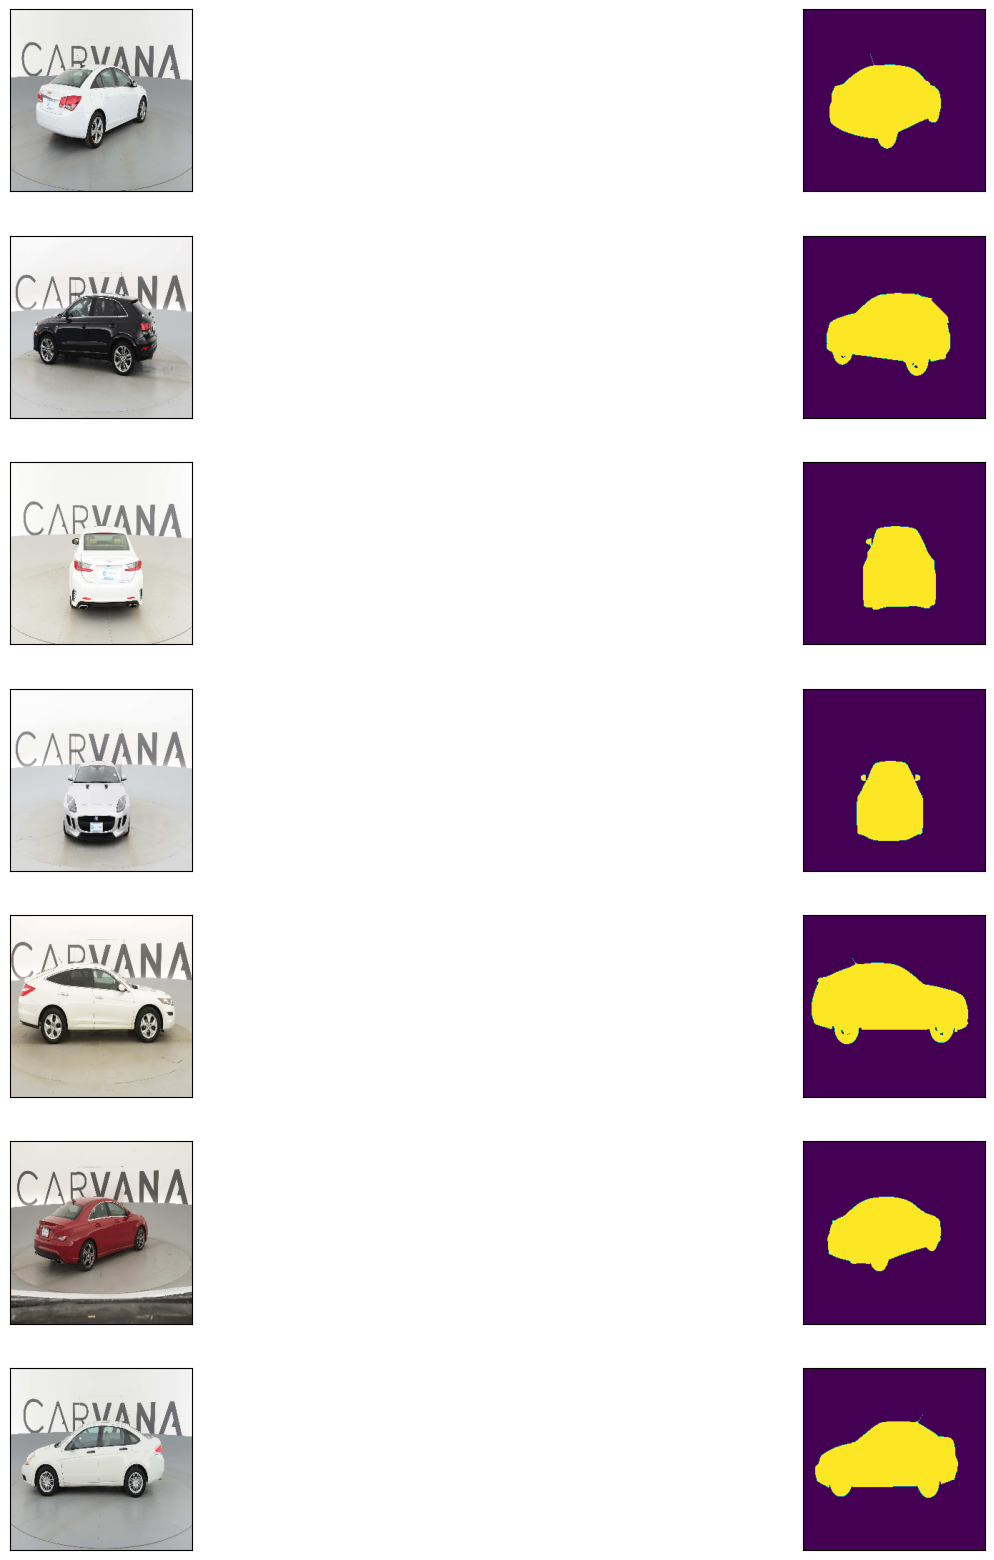

In [ ]:
def imshow(img_list: List[Tuple[str, str]]):
  if len(img_list) > 9:
    raise Exception('len(img_list) must be less than 10')

  fig, axs = plt.subplots(len(img_list), 2, figsize=(16, 16))
  fig.tight_layout()
  for idx, sample in enumerate(img_list):
    image, mask = sample
    axs[idx][0].imshow(image.permute(1, 2, 0))
    axs[idx][1].imshow(mask.permute(1, 2, 0))
    for ax in axs[idx]:
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
  plt.show()


img_list = []
for i in range(7):
  data = dataset[i]
  img_list.append(data)

imshow(img_list)

In [ ]:
def conv_block(in_channels, out_channels):
  return nn.Sequential(
      nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
      nn.BatchNorm2d(out_channels),
      nn.ReLU(),
      nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
      nn.BatchNorm2d(out_channels),
      nn.ReLU(),
  )



class UNET(nn.Module):
  def __init__(
      self,
      in_channels: int = 3,
      out_channels: int = 1,
      features: List[int] = [32, 64, 128],
      ):
    super().__init__()
    self.in_channels = in_channels
    self.out_channels = out_channels
    self.features = features
    self.down = nn.ModuleList()
    self.pool = nn.MaxPool2d(2)
    # down
    for feature in features:
      self.down.append(conv_block(in_channels, feature))
      in_channels = feature
    # bottleneck
    self.bottleneck = conv_block(features[-1], 2 * features[-1])
    # up
    self.up = nn.ModuleList()
    for feature in reversed(features):
      self.up.append(nn.ConvTranspose2d(2 * feature, feature, kernel_size=2, stride=2))
      self.up.append(conv_block(2 * feature, feature))

    self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)


  def forward(self, x):
    skip_connections = []
    for layer in self.down:
      x = layer(x)
      skip_connections.append(x)
      x = self.pool(x)
    skip_connections = skip_connections[::-1]
    x = self.bottleneck(x)
    for i in range(0, len(self.up), 2):
      x = self.up[i](x)
      skip_connection = skip_connections[i // 2]
      if x.shape != skip_connection.shape:
        x = T.functional.resize(x, size=skip_connection.shape[2:])
      concat_skip = torch.cat((skip_connection, x), dim=1)
      x = self.up[i + 1](concat_skip)

    return self.final_conv(x)

In [ ]:
from IPython.display import clear_output
from tqdm.notebook import tqdm
import torch.nn as nn

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

def dice_score(pred, y):
  intercetion = (y * pred).sum().item()
  union = (y + pred).sum().item() + 1e-8
  return intercetion / union


def train_epoch(model, optimizer, criterion, train_loader, tqdm_desc):
  model.train()
  loss, num_correct, num_pixels, count = 0., 0., 0., 0.
  dice = 0.
  for x_batch, y_batch in tqdm(train_loader, desc=f'Train: {tqdm_desc}'):
    x_batch = x_batch.float()
    x_batch, y_batch = x_batch.to(device), y_batch.to(device)
    optimizer.zero_grad()
    pred = model(x_batch)
    loss_ = criterion(pred, y_batch)
    loss_.backward()
    optimizer.step()

    loss += loss_.item()
    pred = nn.functional.sigmoid(pred)
    num_correct += ((pred > .5).type(torch.float32) == y_batch).sum().item()
    num_pixels += torch.numel(pred)
    dice += dice_score(pred, y_batch)
    count += 1

  return loss / count, num_correct / num_pixels, dice / count


def test_epoch(model, criterion, test_loader, tqdm_desc):
  model.eval()
  loss, num_correct, num_pixels, count = 0., 0., 0., 0.
  dice = 0.
  with torch.no_grad():
    for x_batch, y_batch in tqdm(test_loader, desc=f'Test: {tqdm_desc}'):
      x_batch = x_batch.float()
      x_batch, y_batch = x_batch.to(device), y_batch.to(device)
      pred = model(x_batch)
      loss_ = criterion(pred, y_batch)

      loss += loss_.item()
      pred = nn.functional.sigmoid(pred)
      num_correct += ((pred > .5).type(torch.float32) == y_batch).sum().item()
      num_pixels += torch.numel(pred)
      dice += dice_score(pred, y_batch)
      count += 1

    return loss / count, num_correct / num_pixels, dice / count


def train(model, optimizer, criterion, train_loader, test_loader, NUM_EPOCHS=10, scheduler=None):
  train_losses, train_accuracies, train_dices = [], [], []
  test_losses, test_accuracies, test_dices = [], [], []
  for epoch in range(NUM_EPOCHS):
    tqdm_desc = f'{epoch + 1} / {NUM_EPOCHS}'
    loss, accuracy, dice = train_epoch(model, optimizer, criterion, train_loader, tqdm_desc)
    train_losses.append(loss)
    train_accuracies.append(accuracy)

    if scheduler is not None:
      scheduler.step()

    loss, accuracy, dice = test_epoch(model, criterion, test_loader, tqdm_desc)
    test_losses.append(loss)
    test_accuracies.append(accuracy)

    plot(train_losses, train_accuracies, test_losses, test_accuracies)


def plot(train_losses, train_accuracies, test_losses, test_accuracies):
  clear_output()
  NUM_EPOCHS = len(train_losses)
  fig, axs = plt.subplots(1, 2, figsize=(10, 4), sharey=False)
  axs[0].set_title('losses')
  axs[0].grid(True)
  axs[0].set_ylabel('Loss')
  axs[0].plot(list(range(1, NUM_EPOCHS + 1)), train_losses, label='train', c='red')
  axs[0].plot(list(range(1, NUM_EPOCHS + 1)), test_losses, label='test', c='blue')

  axs[1].set_title('accuracies')
  axs[1].grid(True)
  axs[1].set_ylabel('Accuracy')
  axs[1].plot(list(range(1, NUM_EPOCHS + 1)), train_accuracies, label='train', c='red')
  axs[1].plot(list(range(1, NUM_EPOCHS + 1)), test_accuracies, label='test', c='blue')

  for ax in axs:
    ax.set_xlabel('EPOCH')
    ax.legend()

  plt.show()

In [ ]:
NUM_EPOCHS = 10
unet = UNET().to(device)
optimizer = torch.optim.AdamW(unet.parameters(), lr=1.5e-3, weight_decay=.3)
criterion = torch.nn.BCEWithLogitsLoss()
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS)

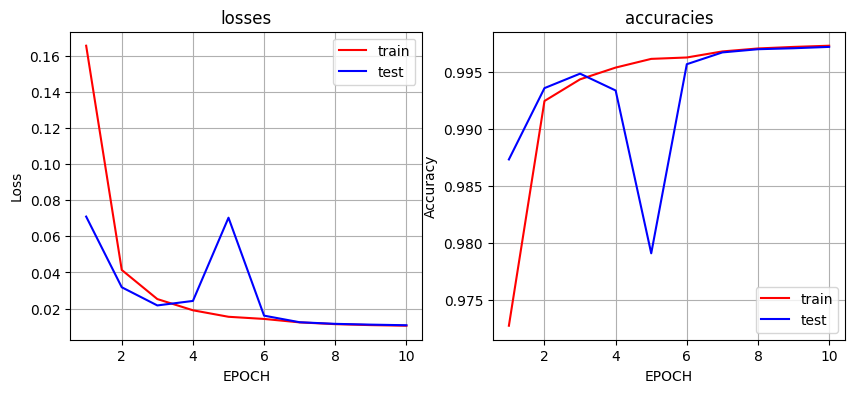

In [ ]:
train(unet, optimizer, criterion, train_loader, test_loader, NUM_EPOCHS, scheduler)

In [ ]:
with torch.no_grad():
  torch.cuda.empty_cache()
torch.cuda.empty_cache()

In [ ]:
@torch.no_grad()
def showresults(img_list: List[Tuple[torch.tensor, torch.tensor]]):
  if len(img_list) > 9:
    raise Exception('len(img_list) must be less than 10')

  fig, axs = plt.subplots(len(img_list), figsize=(10, 8))
  for mask, image in img_list:
    new_image = mask * image
    print(mask.shape, image.shape, new_image.shape)
    plt.imshow(new_image.permute(1, 2, 0))

  plt.show()

tensor([0, 1], dtype=torch.int32)
torch.Size([1, 256, 256]) torch.Size([3, 256, 256]) torch.Size([3, 256, 256])


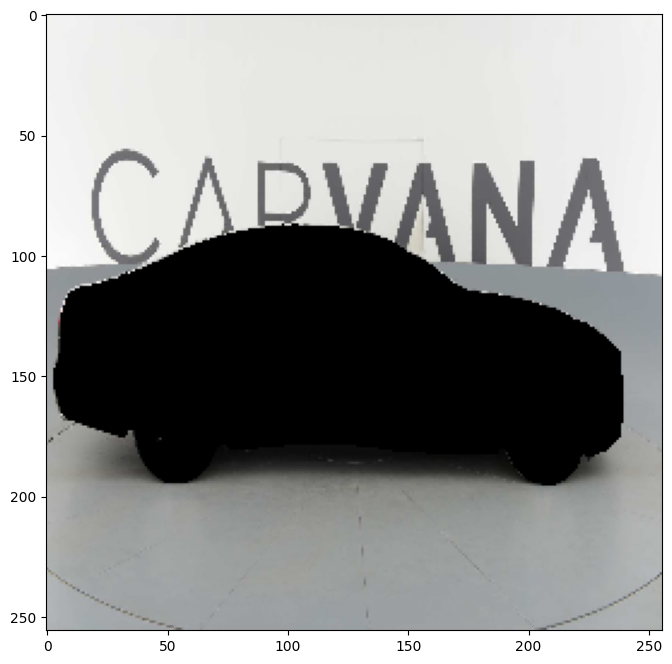

In [ ]:
with torch.no_grad():
  for x, y in test_loader:
    x_ = x
    x = x.float()
    x = x.to(device)
    preds = unet(x).cpu()
    preds = (preds > .5).int()
    preds[preds == 0] = 2
    preds[preds == 1] = 0
    preds[preds == 2] = 1
    print(preds.unique())
    count = 1
    idx = np.random.choice(len(preds))
    preds, x_ = preds[idx], x_[idx]
    lst_images = [(preds, x_)]
    break
showresults(lst_images)

In [ ]:
with torch.no_grad():
  torch.cuda.empty_cache()

In [ ]:
torch.cuda.empty_cache()

In [ ]:
import gc
with torch.no_grad():
  torch.cuda.empty_cache()
gc.collect()

34